## Упражнение на свертку

*Раед Романов*


### Свернем кота
### Грузим картинку котэ

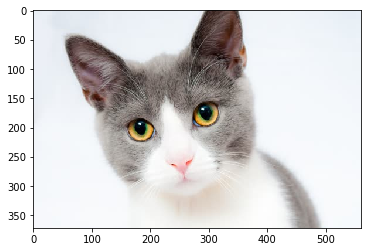

In [2]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [9]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
# cat_tensor.unsqueeze_(0)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Создаем фильтр ядра и заполняем его -1 & 8

In [10]:
filter_kernel = torch.FloatTensor(3, 3, 3).fill_(-1)
filter_kernel[:, 1, 1] = 8
print(filter_kernel.size())
print(cat_tensor.shape[0])

torch.Size([3, 3, 3])
3


## Моя собственная свертка

In [22]:
import math


def my_conv2d(tensor, kernel, stride=1, padding=0):
    flag = 0
    if isinstance(stride, int):
        stride = (stride, stride)
    
    res_size = [0, 0]
    for i in range(1, 3):
        res_size[i - 1] = (tensor.shape[i] - kernel.shape[i] + padding * 2) // stride[i-1] + 1
    res_size = torch.Size(res_size)
    
    res = torch.FloatTensor(res_size)
    for x in range(res_size[0]):
        for y in range(res_size[1]):
            x1 = x * stride[0] - padding
            x2 = x * stride[0] - padding + kernel.shape[1]
            y1 = y * stride[1] - padding
            y2 = y * stride[1] - padding + kernel.shape[2]
            ker_x1 = 0
            ker_x2 = kernel.shape[1]
            ker_y1 = 0
            ker_y2 = kernel.shape[2]
            
            flag = 1 if flag == 0 else 2
            
            if x1 < 0:
                ker_x1 += x1
                x1 = 0
            if x2 > tensor.shape[1]:
                ker_x2 += tensor.shape[1] - x2
                x2 = tensor.shape[1]
            if y1 < 0:
                ker_y1 += y1
                y1 = 0
            if y2 > tensor.shape[2]:
                ker_y2 += tensor.shape[2] - y2
                y2 = tensor.shape[2]
            
            mul = torch.mul(tensor[:, x1:x2, y1:y2], kernel[:, ker_x1:ker_x2, ker_y1:ker_y2])
                
            res[x, y] = mul.sum()
        
    return res


### Делаем свертку картинки ядром

torch.Size([374, 562])


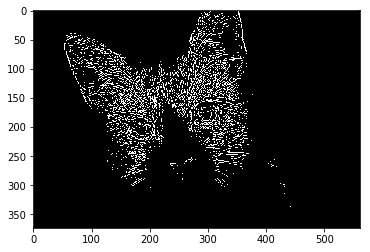

In [23]:
o_image = my_conv2d(cat_tensor, filter_kernel, 1, 2)
o_image[o_image >= 0.5] = 1.0  # бустим границы
o_image[o_image < 0.99] = 0

print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Что будет с картинкой, если мы возьмем ядро  $ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$ и пройдем картинку конволюцией с шагом(stride)=2?


torch.Size([186, 280])


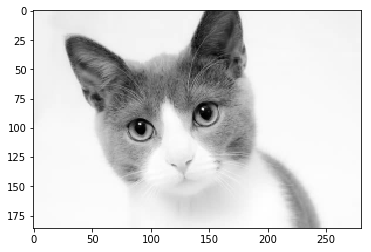

In [24]:
filter_kernelx2 = torch.FloatTensor(3, 2, 2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем

print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

# Ядро свертки с гаусовым распределением

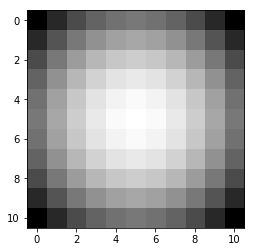

In [25]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2, patern_size//2] = 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

### Делаем свертку

torch.Size([362, 550])


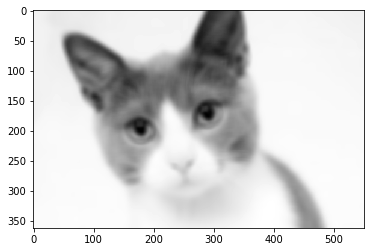

In [26]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))

print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')